<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="Logo HEIG-VD" style="width: 80px;" align="right"/>

# Cours PCD - Labo 1

# Extraction d'attributs pour la détection du spam

## Résumé

Le but de ce travail est de réaliser des expériences de classification d'emails en *spam* ou *ham* (c'est-à-dire non-spam) grâce aux données et au code fourni intégralement dans ce notebook Jupyter.

Votre objectif sera de chercher les meilleurs attributs (*features*) qu'on puisse extraire des emails, ainsi que les classifieurs, afin de maximiser le score F1 de la classification spam/non-spam.  Les classifieurs utilisés seront de la famille Naive Bayes de Scikit-learn.

Veuillez rendre un notebook avec votre meilleure stratégie.  Présentez clairement les options et leurs résultats, et commentez-les brièvement.

*Source* : l'idée du labo vient du [premier notebook de Gan Sie Huai](https://github.com/huai99/Email-Spam-Detection-Python) avec plusieurs changements et mises à jour.

## 1. Obtention des données

Veuillez télécharger l'archive d'emails depuis Cyberlearn.  Ou téléchargez les cinq archives commençant par `20030228_` depuis https://spamassassin.apache.org/old/publiccorpus/.  Décompressez-les dans un dossier de votre choix dont vous indiquerez le chemin relatif dans `path`.

In [125]:
import os
import glob
import numpy as np
import email

In [126]:
path = 'spam_data/'

In [127]:
easy_ham_paths = glob.glob(path+'easy_ham/*')
easy_ham_2_paths = glob.glob(path+'easy_ham_2/*')
hard_ham_paths = glob.glob(path+'hard_ham/*')
spam_paths = glob.glob(path+'spam/*')
spam_2_paths = glob.glob(path+'spam_2/*')

In [128]:
def get_email_content(email_path):
    file = open(email_path,encoding='latin1')
    try:
        msg = email.message_from_file(file)
        for part in msg.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload() # prints the raw text
    except Exception as e:
        print(e)
        
        
def get_email_content_bulk(email_paths):
    email_contents = [get_email_content(o) for o in email_paths]
    return email_contents

## 2. Division en *train* et *test*
Le code suivant vous permet de diviser les données en *train* et *test* (sous-ensembles d'entraînement et de test).  Veuillez l'exécuter pour créer ces deux ensembles.

In [129]:
from sklearn.model_selection import train_test_split

In [130]:
ham_path = [easy_ham_paths, easy_ham_2_paths, hard_ham_paths]
spam_path = [spam_paths, spam_2_paths]

In [131]:
ham_sample = np.array([train_test_split(o) for o in ham_path], dtype=object)

In [132]:
for o in [train_test_split(o) for o in ham_path]:
    print(len(o[0]), len(o[1]))

1875 626
1050 351
188 63


In [133]:
ham_train = np.array([])
ham_test = np.array([])
for o in ham_sample:
    ham_train = np.concatenate((ham_train, o[0]), axis=0)
    ham_test  = np.concatenate((ham_test,  o[1]), axis=0)

In [134]:
ham_train.shape, ham_test.shape

((3113,), (1040,))

In [135]:
spam_sample = np.array([train_test_split(o) for o in spam_path], dtype=object)

In [136]:
for o in [train_test_split(o) for o in spam_path]:
    print(len(o[0]), len(o[1]))

375 126
1047 350


In [137]:
spam_train = np.array([])
spam_test = np.array([])
for o in spam_sample:
    spam_train = np.concatenate((spam_train,o[0]),axis=0)
    spam_test = np.concatenate((spam_test,o[1]),axis=0)

In [138]:
spam_train.shape, spam_test.shape

((1422,), (476,))

In [139]:
ham_train_label = [0]*ham_train.shape[0]
spam_train_label = [1]*spam_train.shape[0]
x_train = np.concatenate((ham_train,spam_train))
y_train = np.concatenate((ham_train_label,spam_train_label))

In [140]:
ham_test_label = [0]*ham_test.shape[0]
spam_test_label = [1]*spam_test.shape[0]
x_test = np.concatenate((ham_test,spam_test))
y_test = np.concatenate((ham_test_label,spam_test_label))

In [141]:
train_shuffle_index = np.random.permutation(np.arange(0,x_train.shape[0]))
test_shuffle_index = np.random.permutation(np.arange(0,x_test.shape[0]))

In [142]:
x_train = x_train[train_shuffle_index]
y_train = y_train[train_shuffle_index]

In [143]:
x_test = x_test[test_shuffle_index]
y_test = y_test[test_shuffle_index]

In [144]:
x_train = get_email_content_bulk(x_train)
x_test = get_email_content_bulk(x_test)

In [145]:
def remove_null(datas,labels):
    not_null_idx = [i for i,o in enumerate(datas) if o is not None]
    return np.array(datas)[not_null_idx],np.array(labels)[not_null_idx]

In [146]:
x_train,y_train = remove_null(x_train,y_train)
x_test,y_test = remove_null(x_test,y_test)

**Question :** combien d'emails y a-t-il dans le jeu d'entraînement et dans le jeu de test ?  Combien de spam et de ham, respectivement ?  Veuillez écrire le code qui fournit les réponses ci-dessous.

In [187]:
print(len(x_train))
print(len(x_test))
print(len(ham_train))
print(len(spam_train))

3812
1264
3113
1422


## 3. Pré-traitement et nettoyage des données

### 3.1 Traitements de bas niveau

In [148]:
import re
import string
from nltk.tokenize import word_tokenize

In [149]:
def remove_hyperlink(word):
    return  re.sub(r"http\S+", "", word)

In [150]:
def to_lower(word):
    result = word.lower()
    return result

In [151]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [152]:
def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [153]:
def remove_whitespace(word):
    result = word.strip()
    return result

In [191]:
def replace_newline(word):
    return word.replace('\n',' ')

**Votre mission :** dans la fonction suivante, insérer dans le tableau `cleaning_utils` les noms des fonctions de pré-traitement que vous souhaitez utiliser afin d'obtenir le meilleur filtre anti-spam.   Veuillez commenter brièvement les raisons de votre choix.

In [155]:
def clean_up_pipeline(sentence):
    cleaning_utils = [to_lower, replace_newline]
    for o in cleaning_utils:
        sentence = o(sentence)
        cleaning_utils
    return sentence

In [156]:
x_train = [clean_up_pipeline(o) for o in x_train]
x_test = [clean_up_pipeline(o) for o in x_test]

### 3.2. Traitements linguistiques avec NLTK

Veuillez installer la librairie NLTK avec Conda ou `pip`, voir instructions à https://www.nltk.org.

In [157]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [158]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [159]:
def remove_stop_words(words):
    result = [i for i in words if i not in ENGLISH_STOP_WORDS]
    return result

In [160]:
def word_stemmer(words):
    return [stemmer.stem(o) for o in words]

In [161]:
def word_lemmatizer(words):
    return [lemmatizer.lemmatize(o) for o in words]

**Votre mission :** dans la fonction suivante, insérer dans le tableau `cleaning_utils` les noms des fonctions de traitement linguistique que vous souhaitez utiliser afin d'obtenir le meilleur filtre anti-spam.  Veuillez commenter brièvement les raisons de votre choix.

In [188]:
def clean_token_pipeline(words):
    cleaning_utils = [remove_stop_words]
    for o in cleaning_utils:
        words = o(words)
    return words

**Remarque:** la tokenization peut prendre plusieurs minutes, vu la quantité de données.

In [163]:
x_train = [word_tokenize(o) for o in x_train]
x_test = [word_tokenize(o) for o in x_test]

In [164]:
x_train = [clean_token_pipeline(o) for o in x_train]
x_test = [clean_token_pipeline(o) for o in x_test]

In [165]:
x_train = [" ".join(o) for o in x_train]
x_test = [" ".join(o) for o in x_test]

# 4. Extraction des attributs (*feature extraction*)

À cette étape, on transforme les textes des emails en une série d'attributs.  Les méthodes proposées par Scikit-learn permettent de décider quels mots on garde comme attributs, puis les valeurs de chaque attribut pour chaque email.  Résultat : au lieu d'une chaîne de caractères, chaque email est représenté par une suite de nombres (de la même taille pour tous).

**Votre mission** : faire des expériences pour choisir entre les deux méthodes suivantes celle qui aboutira aux meilleurs résultats.

In [166]:
from sklearn.feature_extraction.text import CountVectorizer

In [167]:
vectorizer = CountVectorizer()

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [169]:
#vectorizer = TfidfVectorizer()

Transformation des textes des emails en vecteurs d'attributs.

In [170]:
def convert_to_feature(vectorizer, raw_tokenize_data):
    return vectorizer.transform(raw_tokenize_data)

In [171]:
vectorizer.fit(x_train)

CountVectorizer()

In [172]:
x_train_features = convert_to_feature(vectorizer, x_train)
x_test_features  = convert_to_feature(vectorizer, x_test)

## 5. Choix de la méthode de classification et entraînement

Dans cette section, vous allez pouvoir choisir le classifieur.  On vous propose de travailler avec un modèle de type *Naïve Bayes*, à choisir parmi plusieurs variantes disponibles dans Scikit-learn, et qui sont décrites à https://scikit-learn.org/stable/modules/naive_bayes.html.

Voici à titre d'exemple l'utilisation du classifieur *Naïve Bayes Multinomial*.

In [173]:
import sklearn.naive_bayes as nb

In [174]:
clf1 = nb.MultinomialNB()
clf2 = nb.GaussianNB()
clf3 = nb.ComplementNB()
clf4 = nb.CategoricalNB()
clf5 = nb.BernoulliNB()

In [175]:
#clf1.fit(x_train_features.toarray(), y_train) # entraînement du modèle
clf2.fit(x_train_features.toarray(), y_train) # entraînement du modèle
#clf3.fit(x_train_features.toarray(), y_train) # entraînement du modèle
#clf4.fit(x_train_features.toarray(), y_train) # entraînement du modèle
#clf5.fit(x_train_features.toarray(), y_train) # entraînement du modèle

GaussianNB()

In [176]:
#clf1.score(x_train_features.toarray(),y_train) # score F1 du modèle sur les données d'entraînement


In [177]:
clf2.score(x_train_features.toarray(),y_train) # score F1 du modèle sur les données d'entraînement


0.9984260230849947

In [178]:
#clf3.score(x_train_features.toarray(),y_train) # score F1 du modèle sur les données d'entraînement


In [179]:
#clf4.score(x_train_features.toarray(),y_train) # score F1 du modèle sur les données d'entraînement


In [180]:
#clf5.score(x_train_features.toarray(),y_train) # score F1 du modèle sur les données d'entraînement

**Votre mission :** essayer plusieurs classifieurs basés sur l'approche *Naïve Bayes* et choisir celui qui aboutit au meilleur score *sur les données de test*, qui sera calculé dans la section suivante.

## 6. Évaluation du classifieur entraîné

Dans cette section, vous allez demander au classifieur de classer les données de test (non vues à l'entraînement), et calculer (grâce aux réponses correctes) plusieurs scores qui mesurent les performances de détection de spam.  Veuillez répondre aux questions posées en fin de section.

In [181]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [182]:
y_predict = clf2.predict(x_test_features.toarray()) # réponses du système sur les données de test

In [183]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall:    {:.2f}%".format(100 * recall_score(y_test, y_predict)))
print("F1-score:  {:.2f}%".format(100 * f1_score(y_test, y_predict)))

Precision: 94.12%
Recall:    80.93%
F1-score:  87.03%


In [184]:
confusion_matrix(y_test, y_predict) # affichage élémentaire de la matrice de confusion

array([[994,  13],
       [ 49, 208]], dtype=int64)

In [185]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

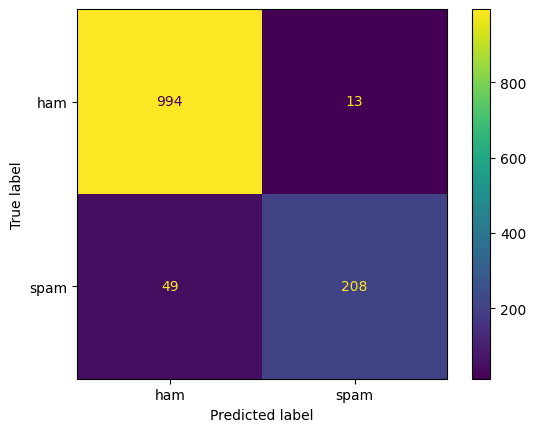

In [186]:
# affichage graphique de la matrice de confusion
ConfusionMatrixDisplay.from_predictions(y_test, y_predict, display_labels = ['ham', 'spam']) 
plt.show()

**Veuillez répondre ici** aux questions suivantes :

1. Quel était votre premier score F1 obtenu ?  Quel est votre meilleur score ?  De combien avez-vous progressé grâce à vos choix judicieux ?

2. Quels choix de pré-traitement (section 3) vous ont conduit-e à la meilleure solution ?

3. Quelle représentation des emails vous a conduit-e à la meilleure solution ?

4. Quel classifieur vous a conduit-e à la meilleure solution ?

**Réponse: Q2**
        Nous avons choisi de prendre la fonction 'to_lower' et 'replace_newline'. En effet, nous pensons que passer le
        texte en minuscule nous permettra de généraliser et ainsi obtenir un modèle plus robuste aux valeurs atypiques.
            
        Nous avons également choisi d''ajouter la fonction 'replace_newline' puisque nous pensons que ces valeurs (espaces blancs)
        ne portent pas de signification en elles-même.

        Concernant les autres fonctions de suppression des nombres ou encore de la ponctuation, nous avons obtenu des
        résultats moins bons avec leur utilisation, c'' est pourquoi nous avons décidé de ne pas les appliquer.

**Réponse: Q3**
        Nous avons décidé d'utiliser uniquement la fonction 'remove_stop_words'. En effet, les mots courts (articles, particules, prépositions...)
        ne portent en général que peu d'information en elles-mêmes. C'est pourquoi nous avons obtenu des meilleures résultats avec l'application de
        cette fonction.
        Dans les langues tel que l'anglais (cas présent) ou le chinois, les thèmes morphologiques (word stem) sont très similaires aux mots. 
        Ce qui nous conduit à penser que les fonctions 'word_stemmer' ainsi que 'word_lemmatizer' n'auront que très peu d'impact sur la 
        performance du modèle. On imagine que pour des langues agglutinante ou flexionelle ces fonctions auraient donné de bon résultats.
    

**Réponse: Q3**
        Nous avons choisi de prendre la méthode 'CountVectorizer()'. En effet, cette méthode se contnte de compter le nombre d'occurences butes
        dans un texte. En revanche le 'TfidfVectorizer' pondère l'importance de chaque mot avec sa fréquence d'apparition dans le texte.

        Après plusieurs essais nous avons clairement une meilleure performance avec le compage brut (CountVectorizer).

**Réponse: Q4**
        

**Fin du Labo 1.**  Veuillez nettoyer ce notebook en gardant seulement les résultats désirés et vos réponses, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.